In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from tqdm import tqdm
import datetime as dt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, MeanShift
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

from data_constructor import DataConstructor
from data_warehouse import DataSource
from modules.models import TimePeriod, DiffParams, ComponentWindow
from modules.data_processing import DataProcessor
from modules.component_orderer import ComponentOrderer
from modules.data_iterator import DataIterator
from modules.data_clustering import DataClustering
from modules.data_visualizer import DataVisualizer
from modules.data_filtering import DataFiltering
from modules.data_storage import DataStorage
from modules.component_manager import ComponentManager

In [18]:
dc = DataConstructor()
ds = DataSource('binance')

time_period = TimePeriod(dt_from=dt.datetime(2022, 1, 1), dt_to=dt.datetime(2023, 1, 1))
df, tickers = dc.construct_df(time_period)

Constructing dataframe: 100%|██████████| 169/169 [05:03<00:00,  1.79s/it]


=== Log ===
=== Diff ===
=== Std normalization ===
=== Ordering tickers ===


In [119]:
tables = ds.contain_tables()
ticker = 'BTCUSDT'
if ticker in tables:
    table_names = [n for n in tables if ticker in n]
    print(table_names)

table_columns = ds.contain_tables()
tables_tickers = [t for t in table_columns if t.endswith('USDT_agg_1m')]
print(len(tables_tickers))

Error on 10.20.90.105:19000 ping: Unexpected EOF while reading bytes
Connection was closed, reconnecting.


['BTCUSDT', 'BTCUSDT_agg_10m', 'BTCUSDT_agg_15m', 'BTCUSDT_agg_1d', 'BTCUSDT_agg_1h', 'BTCUSDT_agg_1m', 'BTCUSDT_agg_1s', 'BTCUSDT_agg_5m']
169


In [4]:
ds.describe('BTCUSDT_agg_1m')

[('dtm', 'DateTime'),
 ('price', 'Float64'),
 ('vol', 'Float64'),
 ('vol_quote', 'Float64'),
 ('trade_count', 'UInt64')]

In [372]:
df_tmp, tickers_tmp = dc.get_agg_1m_data(time_period, fetch_col='price')

stablecoin_tickers = []
for ticker in tickers_tmp:
    df_log = np.log(df_tmp.loc[:, ticker])
    coin_mean = np.mean(df_log)
    if -0.15 < coin_mean < 0.13:
        stablecoin_tickers.append(ticker)

print(stablecoin_tickers)

Constructing dataframe: 100%|██████████| 169/169 [04:25<00:00,  1.57s/it]


['BURGERUSDT', 'BUSDUSDT', 'FLUXUSDT', 'LITUSDT', 'MANAUSDT', 'MATICUSDT', 'MCUSDT', 'MINAUSDT', 'RAYUSDT', 'RNDRUSDT', 'TWTUSDT']


In [138]:
factors, weights, variance = DataProcessor.data_process_pca(df, tickers)
print(f'Variance: {DataProcessor.variance_round(variance)}')

Variance: [0.3992, 0.0118, 0.0079, 0.0074, 0.0069, 0.0068, 0.0067, 0.0067, 0.0066, 0.0066, 0.0065, 0.0065, 0.0065, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0063, 0.0063, 0.0063, 0.0062, 0.0062, 0.0062, 0.0062, 0.0061, 0.0061, 0.006, 0.006, 0.006, 0.0059, 0.0058, 0.0058, 0.0058, 0.0058, 0.0057, 0.0057, 0.0056, 0.0055, 0.0054, 0.0054, 0.0053, 0.0053, 0.0053, 0.0052, 0.0051, 0.005, 0.005, 0.0048, 0.0048, 0.0046, 0.0046, 0.0046, 0.0046, 0.0045, 0.0045, 0.0043, 0.0043, 0.0042, 0.0042, 0.0042, 0.0041, 0.0041, 0.0041, 0.004, 0.004, 0.004, 0.0039, 0.0039, 0.0039, 0.0039, 0.0038, 0.0038, 0.0038, 0.0037, 0.0037, 0.0037, 0.0037, 0.0036, 0.0036, 0.0036, 0.0035, 0.0035, 0.0035, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0033, 0.0033, 0.0033, 0.0033, 0.0032, 0.0032, 0.0032, 0.0032, 0.0032, 0.0031, 0.0031, 0.0031, 0.003, 0.003, 0.003, 0.003, 0.0029, 0.0029, 0.0029, 0.0029, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0027, 0.0027, 0.0026, 0.0026, 0.0026, 0.0026, 0.0025, 0.0025, 0.0025, 0.0025, 0.0024, 0

In [6]:
dbscan = DBSCAN(eps=0.04, min_samples=3)

slice_weights = weights[:3]
dbscan_labels = dbscan.fit_predict(slice_weights.T)
dbscan_labels

array([ 0,  1,  0,  0,  0,  2,  0,  0,  0, -1,  0,  1,  0,  0,  2,  0,  0,
        0,  0,  0,  0,  2,  0,  0,  0,  2,  2, -1,  0,  2,  0,  0,  0,  0,
        2,  0,  2,  0,  0,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  2,  2,  0,  2,  0,  2,  0,  2,  0,  0,  0,  0,  2,  0,  0, -1,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  2,  2,  0,  0,  0,  0,  1,  0,  0,  0,  2,  0,  2,  2,  2,  2,
        0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
        2,  0,  0,  0,  2,  0,  0,  2,  2,  0,  0,  0,  2,  2,  2,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

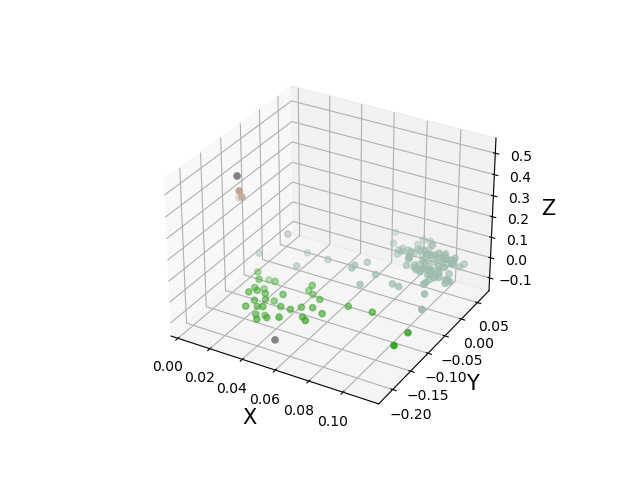

(<Figure size 640x480 with 1 Axes>,
 <Axes3DSubplot: xlabel='X', ylabel='Y', zlabel='Z'>)

In [7]:
slice_weights = weights[:3]
DataVisualizer.plot_3d_labeled_point_cloud(slice_weights.T, dbscan_labels)

In [8]:
mean_shift = MeanShift()

slice_weights = weights[:3]
meanshift_labels = mean_shift.fit_predict(slice_weights.T)
meanshift_labels

array([0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 3, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

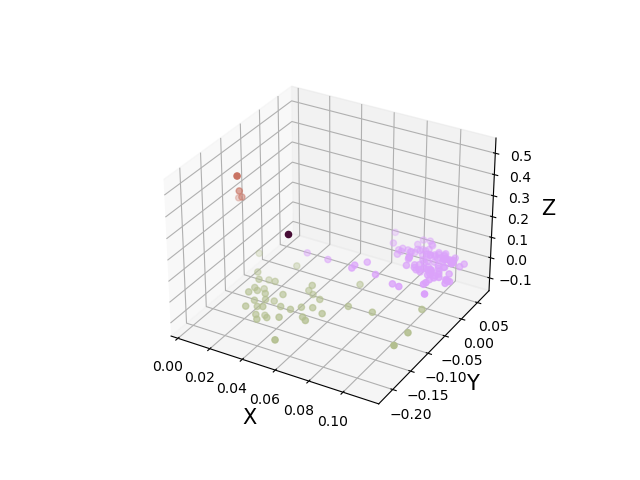

(<Figure size 640x480 with 1 Axes>,
 <Axes3DSubplot: xlabel='X', ylabel='Y', zlabel='Z'>)

In [9]:
slice_weights = weights[:3]
# DataVisualizer.plot_3d_point_cloud(slice_weights)
DataVisualizer.plot_3d_labeled_point_cloud(slice_weights.T, meanshift_labels)

In [10]:
idxes = np.where(meanshift_labels == 2)[0]
label_tickers = [tickers[i] for i in idxes]
df[label_tickers]

,ACMUSDT,ASRUSDT,ATMUSDT,OGUSDT
1,0.000000,0.346108,0.000000e+00,-0.207170
2,0.000000,0.000000,0.000000e+00,3.878448
3,0.000000,0.000000,0.000000e+00,-1.037563
4,0.000000,1.760692,0.000000e+00,-0.604315
5,-0.098991,0.062006,1.031714e-13,0.548741
...,...,...,...,...
525596,0.143548,0.000000,0.000000e+00,-0.575528
525597,0.000000,0.000000,0.000000e+00,0.000000
525598,0.000000,0.000000,0.000000e+00,0.000000
525599,0.000000,0.000000,0.000000e+00,0.171189


In [11]:
# idxes = list(np.where(dbscan_labels == -1)[0])
# ticker_slice = np.array(tickers)[idxes]
# df[ticker_slice]

In [12]:
# idxes = list(np.where(dbscan_labels == 1)[0])
# ticker_slice = np.array(tickers)[idxes]
# df[ticker_slice]

In [13]:
# idxes = list(np.where(dbscan_labels == -1)[0])
# ticker_slice = np.array(tickers)[idxes]
# df[ticker_slice]

In [15]:
period = TimePeriod(dt_from=dt.datetime(2022, 1, 1), dt_to=dt.datetime(2023, 1, 1))

df_test = ds.as_pandas('BTCUSDT_agg_1m', columns=['dtm', 'price', 'vol', 'vol_quote', 'trade_count'], time_period=period)
df_test

Error on 10.20.90.105:19000 ping: Unexpected EOF while reading bytes
Connection was closed, reconnecting.


,dtm,price,vol,vol_quote,trade_count
0,2022-01-01 00:00:00,46243.187023,40.57574,1.875978e+06,796
1,2022-01-01 00:01:00,46280.518808,42.38106,1.961908e+06,973
2,2022-01-01 00:02:00,46346.134249,51.29955,2.377414e+06,1238
3,2022-01-01 00:03:00,46357.247943,30.45894,1.412004e+06,953
4,2022-01-01 00:04:00,46324.935296,20.96029,9.710099e+05,591
...,...,...,...,...,...
525596,2022-12-31 23:56:00,16539.476986,38.58840,6.382267e+05,1536
525597,2022-12-31 23:57:00,16537.931442,53.35978,8.824495e+05,2088
525598,2022-12-31 23:58:00,16537.646930,28.88239,4.776434e+05,1267
525599,2022-12-31 23:59:00,16539.240189,69.99944,1.157778e+06,2536


In [ ]:
# Basically tries to download data on multiple threads

def fetch_data(ticker, time_period):
    # Calculates the data amount
    dt_from = time_period.dt_from
    dt_to = time_period.dt_to
    diff_seconds = (dt_to - dt_from).total_seconds()
    data_amount = diff_seconds // 60 + 1 # minutes
    
    df_fetch = ds.as_pandas(ticker, columns=['dtm', 'price'], time_period=time_period)

    return df_fetch['price']

# num_cores = multiprocessing.cpu_count() // 2
num_cores = 4

time_period = TimePeriod(dt_from=dt.datetime(2022, 1, 1), dt_to=dt.datetime(2023, 1, 1))

ds_tables = ds.contain_tables()
tickers = [t for t in ds_tables if t.endswith('USDT_agg_1m')][:8]

# Calculates the data amount
dt_from = time_period.dt_from
dt_to = time_period.dt_to
diff_seconds = (dt_to - dt_from).total_seconds()
data_amount = diff_seconds // 60 + 1 # minutes

# Creates dataframe from a date array
dt_range = pd.date_range(dt_from, dt_to, freq='1Min')
df = pd.DataFrame(dt_range, columns=['dtm'])

df_fetch = ds.as_pandas('BTCUSDT_agg_1m', columns=['dtm', 'price'], time_period=time_period)

df = df.join(df_fetch['price'])

df
# fetched_data = Parallel(n_jobs=num_cores, prefer="threads")(delayed(fetch_data)(ticker=ticker, time_period=time_period) for ticker in tqdm(tickers))
# fetched_data

In [ ]:
# Basically tries to join all the tables together to get all the data in one call

import time
from clickhouse_driver import Client
import pandas as pd

from modules.models import TimePeriod

class DataSource:
    database_name = 'binance'
    _client = None

    def __init__(self, use_database: str = 'binance'):
        self.database = use_database
        self._client = Client('10.20.90.105', verify=False, secure=False, user='username', password='password', port=19000)
    
    def execute(self, query):
        return self._client.execute(query)
    
    def contain_tables(self, database_name: str = 'binance'):
        # list of tables in database
        q = 'SHOW TABLES FROM binance'
        return [a[0] for a in self.execute(q)]
    
    def as_pandas(self, column: str, main_table: str, tables: list[str], time_period: TimePeriod = None):
        dt = 'dt'
        if 'agg' in main_table:
            dt = 'dtm'
        
        main_table_abbr = main_table.replace('_agg_1m', '')
        
        select_query = f'SELECT {main_table_abbr}.{dt}, {main_table_abbr}.{column} AS {main_table_abbr}'
        from_query = f' FROM {str(self.database_name)}.{main_table} {main_table_abbr}'
        cols = [dt, main_table_abbr]
        
        for table in tables:
            table_abbr = table.replace('_agg_1m', '')
            
            select_query += f', {table_abbr}.{column} AS {table_abbr}'
            from_query += f' LEFT JOIN {str(self.database_name)}.{table} {table_abbr} ON {main_table_abbr}.{dt} = {table_abbr}.{dt}'
            cols += [table_abbr]
        
        query = select_query + from_query  
        
        if time_period is not None:
            query += f" WHERE ({main_table_abbr}.{dt} BETWEEN '{str(time_period.dt_from)}' AND '{str(time_period.dt_to)}')"
        
        query += f' ORDER BY {main_table_abbr}.{dt}'
        
        print(query)
        
        df = pd.DataFrame(self._client.execute(query), columns=cols)

        return df

start_time = time.time()

ds = DataSource('binance')

time_period = TimePeriod(dt_from=dt.datetime(2022, 1, 1), dt_to=dt.datetime(2023, 1, 1))

ds_tables = ds.contain_tables()
tickers = [t for t in ds_tables if t.endswith('USDT_agg_1m')]
main_table = 'BTCUSDT_agg_1m'
tickers.remove(main_table)

df_fetch = ds.as_pandas(column='price', main_table=main_table, tables=tickers, time_period=time_period)

print("--- %s seconds ---" % (time.time() - start_time))

df_fetch

In [340]:
df_iter = DataIterator(df.iloc[:10080 + (15 * 1000)], reading_step=15)
# df_iter.print_state()

orderer = ComponentOrderer()
orderer.add_list(df_iter)
orderer.order_component_steps()
comp_factors, comp_weights, comp_variance, comp_correlation = orderer.get_ordered_components()

# orderer.print_state()

Processing components:   0%|          | 0/1001 [00:00<?, ?it/s]

Ordering components: 100%|██████████| 1001/1001 [00:03<00:00, 260.45it/s]


In [330]:
# df_test = pd.DataFrame({
#     'dtm': [f"2022-01-01 00:0{i}:00.0" for i in range(10)], 
#     'BTCUSDT': np.random.rand(10) * 20,
#     'BTC2USDT': np.random.rand(10) * 30,
#     'BTC3USDT': np.random.rand(10) * 40,
# })
# tickers_test = ['BTCUSDT', 'BTC2USDT', 'BTC3USDT']
# df_iter = DataIterator(df_test, reading_window=6)
# df_iter.print_state()

df_iter = DataIterator(df, reading_step=1)
df_iter.print_state()

=== Data shapes ===
df: (525600, 148), tickers: ['AAVEUSDT', 'ACMUSDT', 'ADAUSDT', 'ALGOUSDT', 'ALICEUSDT', 'AMPUSDT', 'ANKRUSDT', 'ANTUSDT', 'ARUSDT', 'ASRUSDT', 'ATAUSDT', 'ATMUSDT', 'ATOMUSDT', 'AUDIOUSDT', 'AUTOUSDT', 'AVAXUSDT', 'AXSUSDT', 'BAKEUSDT', 'BANDUSDT', 'BATUSDT', 'BCHUSDT', 'BETAUSDT', 'BLZUSDT', 'BNBUSDT', 'BNXUSDT', 'BTCUSDT', 'BURGERUSDT', 'BUSDUSDT', 'C98USDT', 'CAKEUSDT', 'CELOUSDT', 'CELRUSDT', 'CHRUSDT', 'CHZUSDT', 'COCOSUSDT', 'COMPUSDT', 'COSUSDT', 'COTIUSDT', 'CRVUSDT', 'CTXCUSDT', 'CVXUSDT', 'DASHUSDT', 'DENTUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'ENJUSDT', 'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FETUSDT', 'FIDAUSDT', 'FILUSDT', 'FISUSDT', 'FLOWUSDT', 'FLUXUSDT', 'FTMUSDT', 'FXSUSDT', 'GALAUSDT', 'GRTUSDT', 'GTCUSDT', 'HBARUSDT', 'HIGHUSDT', 'HOTUSDT', 'ICPUSDT', 'ILVUSDT', 'INJUSDT', 'IOTXUSDT', 'JASMYUSDT', 'KAVAUSDT', 'KLAYUSDT', 'KNCUSDT', 'KSMUSDT', 'LINAUSDT', 'LINKUSDT', 'LITUSDT', 'LPTUSDT', 'LRCUSDT', 'LTCUSDT', 'LUNAUSDT', 'MANAU

In [134]:
# factors.shape = (10080, 147)
# weights.shape = (147, 147)
# timestamps.shape = (10080,)
# variance.shape = (147,)
# correlation.shape = (147,)
# step_order.shape = (147,)

(147,)

In [ ]:
orderer_test.print_state()

In [48]:
df_iter = DataIterator(df, reading_step=15)

date_from = "2022-01-01 00:01:00"
date_to = "2022-02-01 00:00:00"
df_iter.set_time_range(time_from=date_from, time_to=date_to)

file_dir = 'data/zarr_experiment_1'
manager = ComponentManager(file_dir)

manager.proc_list(df_iter)

Processing components:   0%|          | 0/2304 [00:00<?, ?it/s]

In [60]:
manager.order_component_steps()

Determining component steps: 100%|██████████| 2304/2304 [05:00<00:00,  7.68it/s]


In [51]:
root = manager.components.root_map